# Preprocess

In [1]:
import re
import os
from os.path import join
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import xarray as xr
from glob import glob
from joblib import Parallel, delayed

import kaggle
import matplotlib.pyplot as plt

## Download from Kaggle

In [2]:
raw_path = '/tmp/zcpcb'
if not os.path.exists(raw_path):
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('zeelpatel19310068/cpcb-full-2017-2023', path=raw_path, unzip=True)

## Load station locations

In [3]:
with xr.open_dataset("stations.nc") as stations_ds:
    pass
stations_df = stations_ds.to_dataframe().reset_index()
# substitute spaces, commas and dashes with underscores and then convert multiple underscores to single
stations_df['station'] = stations_df['station'].apply(lambda x: re.sub(r'[\s,-]+', '_', x))
stations_df.set_index('station', inplace=True)
stations_df.head(2)

,lat,lon,elevation,pop_1km,pop_2km,pop_3km
station,,,,,,
Alipur_Delhi_DPCC,28.815329,77.15301,232.723892,5191.0,24590.0,56670.0
Arya_Nagar_Bahadurgarh_HSPCB,28.670100,76.92540,235.903046,3634.0,47417.0,109756.0


## Combine

In [4]:
# read multiple csv files at once
csv_data = glob(join(raw_path, '*.csv'))
print(len(csv_data))

def read_csv(file):
    file_name = file.split('/')[-1].replace('.csv', '')
    try:
        station_name = re.search(r'Raw_data_15Min_\d\d\d\d_site_\d*_(.*)_15Min', file_name).group(1)
    except AttributeError:
        print(file_name)
        raise AttributeError
    # fix station_name
    station_name = re.sub(r'[\s,_-]+', '_', station_name)

    df = pd.read_csv(file)
    df['station'] = station_name
    
    # remove units
    df.columns = [col.split(" ")[0] for col in df.columns]
    
    # add lat lon
    # try:
    #     df['lat'] = stations_df.loc[station_name]['lat'].item()
    #     df['lon'] = stations_df.loc[station_name]['lon'].item()
    # except KeyError:
    #     print(station_name, "was not found in stations_df")
    
    return df

df = pd.concat(Parallel(n_jobs=32)(delayed(read_csv)(file) for file in tqdm(csv_data))).reset_index(drop=True)

463


  0%|          | 0/463 [00:00<?, ?it/s]

In [5]:
df.head(2)

,Timestamp,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,...,AT,RH,WS,WD,RF,TOT-RF,SR,BP,VWS,station
0,2021-01-01 00:00:00,NaN,467.0,237.5,34.5,212.0,44.7,18.8,3.3,9.8,...,15.7,88.4,0.3,251.7,0.0,0.0,1.8,994.3,NaN,Major_Dhyan_Chand_National_Stadium_Delhi_DPCC
1,2021-01-01 00:15:00,353.0,467.0,237.2,31.1,210.1,43.5,19.7,3.2,9.4,...,15.6,88.7,0.6,272.0,0.0,0.0,1.6,994.3,NaN,Major_Dhyan_Chand_National_Stadium_Delhi_DPCC


In [6]:
print(set(df.station.unique()) - set(stations_df.index.unique()))
print(set(stations_df.index.unique()) - set(df.station.unique()))

{'New_Moti_Bagh_Delhi_MHUA', 'Pusa_Delhi_IMD'}
{'East_Arjun_Nagar_Delhi_CPCB'}


* "New_Moti_Bagh_Delhi_MHUA" is a new station and thus it has data from 9th month of 2023. We exclude it.
* "Pusa_Delhi_IMD" has no location available on CPCB map so we exclude it.
* "East_Arjun_Nagar_Delhi_CPCB" has no data so we exclude it.

In [7]:
stations_to_remove = ["New_Moti_Bagh_Delhi_MHUA", "Pusa_Delhi_IMD", "East_Arjun_Nagar_Delhi_CPCB"]
print(df.shape)
df = df[~df.station.isin(stations_to_remove)]
print(df.shape)

(16218336, 26)
(15937920, 26)


## Convert time to time

In [9]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values(['station', 'Timestamp'])
df.head(5)

,Timestamp,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,...,AT,RH,WS,WD,RF,TOT-RF,SR,BP,VWS,station
10048704,2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Alipur_Delhi_DPCC
10048705,2017-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Alipur_Delhi_DPCC
10048706,2017-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Alipur_Delhi_DPCC
10048707,2017-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Alipur_Delhi_DPCC
10048708,2017-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Alipur_Delhi_DPCC


## Resample to 1 hour

In [10]:
# add lag of 7.5 minutes to the timestamp
df["Timestamp_lag"] = df["Timestamp"] + pd.Timedelta(minutes=7.5)
# take mean over 4 concecutives rows using index//4
columns = df.columns.tolist()
columns.remove('station')
join_rule = {col: 'mean' for col in columns}
join_rule.update({'station': "first"})
new_df = df.groupby(df.index // 4).agg(join_rule)  # This is dangerous, but we are sure that the index is continuous
new_df = new_df.sort_values(['station', 'Timestamp'])
new_df.head(2)

,Timestamp,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,...,RH,WS,WD,RF,TOT-RF,SR,BP,VWS,Timestamp_lag,station
2512176,2017-01-01 00:22:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2017-01-01 00:30:00,Alipur_Delhi_DPCC
2512177,2017-01-01 01:22:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2017-01-01 01:30:00,Alipur_Delhi_DPCC


In [11]:
test_df = new_df[new_df.station == 'Sector_125_Noida_UPPCB']
test_df.head(2)

,Timestamp,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,...,RH,WS,WD,RF,TOT-RF,SR,BP,VWS,Timestamp_lag,station
1261920,2017-05-01 00:22:30,131.00,226.50,3.625,30.875,19.375,35.325,84.625,0.8875,31.475,...,36.75,2.300,211.75,0.0,0.0,4.0,737.0,NaN,2017-05-01 00:30:00,Sector_125_Noida_UPPCB
1261921,2017-05-01 01:22:30,106.75,183.75,3.725,29.225,18.575,33.025,80.050,0.8475,25.450,...,37.25,2.475,210.75,0.0,0.0,4.0,737.0,NaN,2017-05-01 01:30:00,Sector_125_Noida_UPPCB


In [12]:
s_new_df = new_df.drop_duplicates(subset=["station"]).set_index('station')
for station in tqdm(s_new_df.index):
    tmp_df = new_df[new_df.station == station]
    assert (tmp_df['Timestamp_lag'] - tmp_df['Timestamp_lag'].shift(1)).value_counts().shape[0] == 1

  0%|          | 0/65 [00:00<?, ?it/s]

In [13]:
cpcb_ds = new_df.rename(columns={'Timestamp_lag': 'time'}).set_index(['time', 'station']).drop(columns="Timestamp").to_xarray()
lats = [stations_df.loc[station]['lat'] for station in cpcb_ds.station.values]
lons = [stations_df.loc[station]['lon'] for station in cpcb_ds.station.values]
elevations = [stations_df.loc[station]['elevation'] for station in cpcb_ds.station.values]
pop_1km = [stations_df.loc[station]['pop_1km'] for station in cpcb_ds.station.values]
pop_2km = [stations_df.loc[station]['pop_2km'] for station in cpcb_ds.station.values]
pop_3km = [stations_df.loc[station]['pop_3km'] for station in cpcb_ds.station.values]
# add lat and lon as coordinates
cpcb_ds.coords['lat'] = ('station', lats)
cpcb_ds.coords['lon'] = ('station', lons)
# add elevation data
cpcb_ds.coords['elevation'] = ('station', elevations)
# add population data
cpcb_ds.coords['pop_1km'] = ('station', pop_1km)
cpcb_ds.coords['pop_2km'] = ('station', pop_2km)
cpcb_ds.coords['pop_3km'] = ('station', pop_3km)

cpcb_ds

<xarray.Dataset>
Dimensions:      (time: 61344, station: 65)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-01T00:30:00 ... 2023-12-31T23:...
  * station      (station) object 'Alipur_Delhi_DPCC' ... 'Wazirpur_Delhi_DPCC'
    lat          (station) float64 28.82 28.65 28.67 28.7 ... 28.45 28.67 28.7
    lon          (station) float64 77.15 77.32 76.93 77.18 ... 77.03 77.32 77.17
    elevation    (station) float64 232.7 228.1 235.9 239.1 ... 245.6 227.6 236.9
    pop_1km      (station) float64 5.191e+03 1.125e+05 ... 1.575e+05 1.543e+05
    pop_2km      (station) float64 2.459e+04 3.452e+05 ... 4.835e+05 5.677e+05
    pop_3km      (station) float64 5.667e+04 9.286e+05 ... 1.226e+06 1.084e+06
Data variables: (12/24)
    PM2.5        (time, station) float64 nan 162.0 nan nan ... 88.67 207.8 213.8
    PM10         (time, station) float64 nan 227.0 nan nan ... nan 344.5 311.0
    NO           (time, station) float64 nan 35.43 nan nan ... 21.74 3.15 12.78
    NO2          (time, station) float64 nan 84.29 nan nan ... 20.34 16.55 66.12
    NOx          (time, station) float64 nan 123.5 nan nan ... 52.07 19.68 78.88
    NH3          (time, station) float64 nan 101.2 nan nan ... nan 27.98 31.62
    ...           ...
    WD           (time, station) float64 nan 127.2 nan nan ... 132.4 228.5 190.5
    RF           (time, station) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    TOT-RF       (time, station) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SR           (time, station) float64 nan 12.25 nan nan ... 29.66 5.25 7.625
    BP           (time, station) float64 nan 740.0 nan nan ... 731.4 983.6 978.3
    VWS          (time, station) float64 nan nan nan nan ... nan -0.05 nan nan

In [14]:
cpcb_ds.to_netcdf('cpcb_17_to_23.nc')

## Appendix

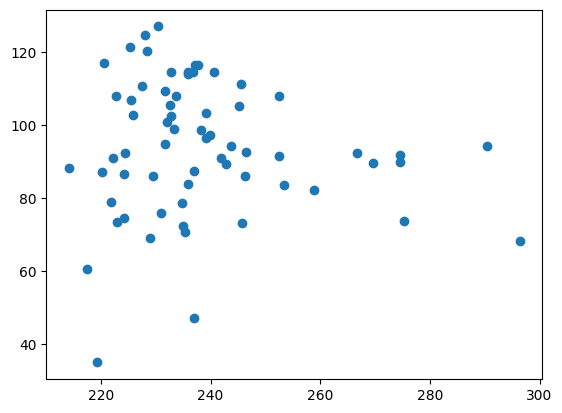

In [ ]:
vals = cpcb_ds['PM2.5'].sel(time='2022').mean(dim='time').values
elevations = cpcb_ds['elevation'].values
plt.scatter(elevations, vals)

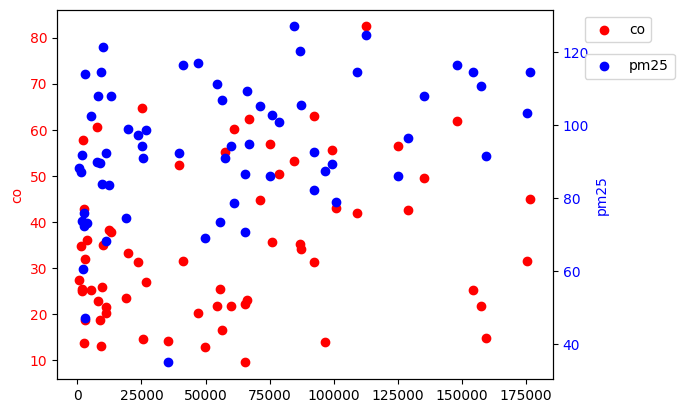

In [ ]:
pm25 = cpcb_ds['PM2.5'].sel(time='2022').mean(dim='time').values
co = cpcb_ds['NO2'].sel(time='2022').mean(dim='time').values
# no2 = cpcb_ds['NO2'].sel(time='2022').mean(dim='time').values
fig, ax = plt.subplots()
ax.scatter(pop_0p01, co, label='co', color='r')
# color y axis labels red
ax.tick_params(axis='y', labelcolor='r')
ax.set_ylabel('co', color='r')
twinx = ax.twinx()
twinx.scatter(pop_0p01, pm25, label='pm25', color='b')
twinx.tick_params(axis='y', labelcolor='b')
twinx.set_ylabel('pm25', color='b')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
twinx.legend(bbox_to_anchor=(1.05, 0.9), loc='upper left')

In [ ]:
cpcb_ds['PM2.5'].sel(time='2018').mean(dim='time').to_dataframe().sort_values('PM2.5', ascending=False).head(60)

,lat,lon,elevation,pop_0.01,pop_0.02,pop_0.03,PM2.5
station,,,,,,,
Alipur_Delhi_DPCC,28.815329,77.153010,232.723892,5191.0,184023.0,70160.0,221.467960
Murthal_Sonipat_HSPCB,29.027200,77.062100,236.980927,3109.0,151495.0,32954.0,205.034759
Anand_Vihar_Delhi_DPCC,28.647622,77.315809,228.054230,112532.0,2915195.0,974016.0,163.368550
Jahangirpuri_Delhi_DPCC,28.732820,77.170633,230.450912,84436.0,1647462.0,630163.0,145.676507
Mundka_Delhi_DPCC,28.684678,77.076574,232.746765,108892.0,2243819.0,1037958.0,142.930529
New_Collectorate_Baghpat_UPPCB,28.974801,77.213357,235.851746,3180.0,97259.0,36528.0,141.469549
NISE_Gwal_Pahari_Gurugram_IMD,28.422681,77.148944,275.230927,1788.0,114877.0,18738.0,140.645498
Vasundhara_Ghaziabad_UPPCB,28.660335,77.357256,224.496262,39565.0,1674880.0,526016.0,139.196069
RIICO_Ind._Area_III_Bhiwadi_RSPCB,28.194909,76.862296,290.480988,25040.0,126956.0,70095.0,136.860355
